<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3, ResNet50, ResNet50V2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [13]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)
BATCH_SIZE = 64


# Load the images from the test folder and create a dataset

def build_trainset(subset):
    return image_dataset_from_directory(
                        "archive/train",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        # shuffle=False,
                        seed=42,
                        validation_split=0.2,
                        subset=subset)

# Load the training and validation datasets
train_ds_raw = build_trainset("training")
val_ds_raw = build_trainset("validation")

class_names = train_ds_raw.class_names
print(class_names)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [14]:
# Preprocessing of the data
AUTOTUNE = tf.data.experimental.AUTOTUNE

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(Rescaling(1./255))
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)

def preprocess(image, label):
    image = preprocessing_model(image)
    return image, label

train_ds = train_ds_raw.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Text(0.5, 1.0, 'Preprocessed Image')

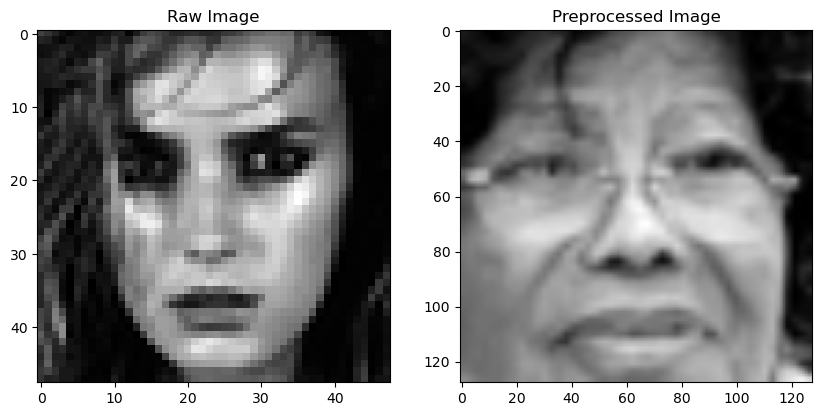

In [15]:
#show difference between original and preprocessed image

# Extract one batch of data from the datasets
raw_batch = train_ds_raw.take(1)
preproc_batch = train_ds.take(1)

# Extract images from the batches (assuming the batches contain (image, label) tuples)
for raw_image, _ in raw_batch:
    image_raw = raw_image.numpy()
    break

for prep_image, _ in preproc_batch:
    image_prep = prep_image.numpy()
    break

# If the preprocessed image is in RGB, convert it back to grayscale for comparison
image_raw = image_raw[0, :, :, 0]
image_prep = image_prep[0, :, :, 0]

fig , ax = plt.subplots(1,2 , figsize=(10,5))
ax[0].imshow(image_raw, cmap='gray')
ax[1].imshow(image_prep, cmap='gray')
ax[0].set_title('Raw Image')
ax[1].set_title('Preprocessed Image')


In [16]:
# adding augmentation to the dataset 

augmentation = False

if augmentation:
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
    ])

    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)


In [17]:
# Get class names and the size of the data sets
train_size = train_ds.cardinality().numpy()
val_size = val_ds.cardinality().numpy()

train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Repeat training data set to ensure enough data
train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

In [99]:
# Load the EfficientNetV2 model as the base model and freeze the weights
# Don't add top layer and add our own top

# #Use ResNet50 as the base model
base_model = ResNet50V2(
    input_shape=(model_pixels, model_pixels, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


# Unfreeze the top layers of the base model
base_model.trainable = False




# Freeze all layers except the top layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Add layers on top of the base model
model = Sequential([base_model,
                    # GlobalAveragePooling2D(),
                    # Flatten(),
                    Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                    BatchNormalization(),
                    Dropout(0.2),
                    Dense(len(class_names),  activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
                    ])

# Build the model
model.build((None,)+(model_pixels, model_pixels)+(3,))
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,951 (91.93 MB)

 Trainable params: 533,575 (2.04 MB)

 Non-trainable params: 23,565,376 (89.89 MB)

In [100]:
#compile the model using the base optimizer for the base model layers and the final optimizer for the final layers
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005),# momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])




steps_per_epoch = train_size // (BATCH_SIZE * 2)
validation_steps = val_size // BATCH_SIZE

print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)
print("train_size: ", train_size)

steps_per_epoch:  179
validation_steps:  89
train_size:  22968


In [101]:
# Train the model

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1,  min_lr=1e-7,)# factor=0.5)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='val_loss')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

# with tf.device('/device:GPU:0'):
hist = model.fit(train_ds,
                  batch_size=BATCH_SIZE,
                  epochs=10,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_ds,
                  validation_steps=validation_steps,
                  callbacks=[reduce_lr, checkpoint, tensorboard]#, early_stopping]
                  ).history
  



Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.2839 - loss: 2.1187 - val_accuracy: 0.4182 - val_loss: 1.6524 - learning_rate: 5.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.3880 - loss: 1.7189 - val_accuracy: 0.4612 - val_loss: 1.5141 - learning_rate: 5.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.4439 - loss: 1.5518 - val_accuracy: 0.4649 - val_loss: 1.4947 - learning_rate: 5.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.4551 - loss: 1.5158 - val_accuracy: 0.4804 - val_loss: 1.4450 - learning_rate: 5.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.4958 - loss: 1.4137 - val_accuracy: 0.4818 - val_loss: 1.4445 - learning_rate: 5.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.4822 - loss: 1.4205 - val_accuracy: 0.4858 - val_loss: 1.4229 - learning_rate: 5.0000e-04
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - acc

#### Load model

In [17]:

#load model 
# model = tf.keras.models.load_model("ResNet50V2_v4_nofinetuning.keras")

#load training checkpoints
# backup_model = tf.keras.models.load_model("model_checkpoint.keras")

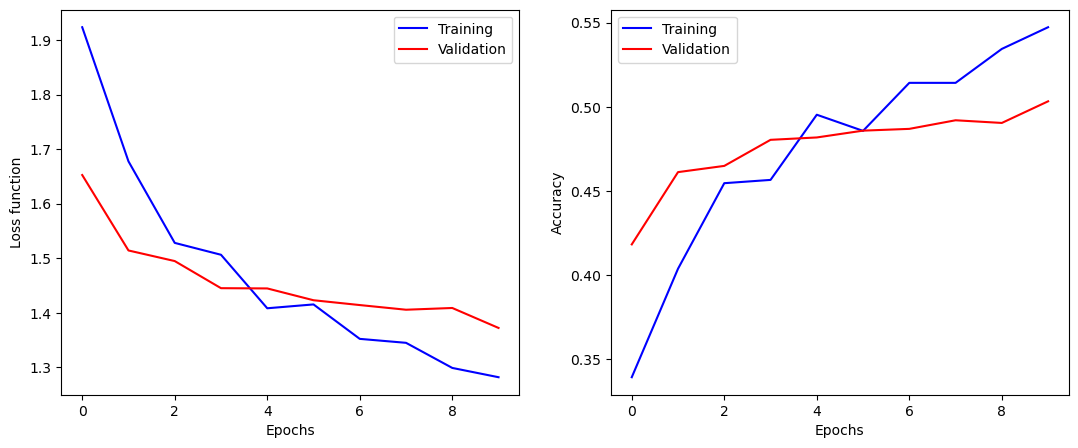

In [102]:

fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].plot(hist["loss"], label="Training", c='b')
ax[0].plot(hist["val_loss"], label="Validation", c='r')
ax[0].set_ylabel("Loss function")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(hist["accuracy"], label="Training", c='b')
ax[1].plot(hist["val_accuracy"], label="Validation", c='r')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].legend()


,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.514403,3.086024,0.477177,3.175380,0.005
1,0.504801,3.096589,0.481945,3.159662,0.005
2,0.522100,3.038798,0.484058,3.146750,0.005
3,0.525663,3.042699,0.485115,3.132902,0.005
4,0.536513,2.998234,0.480536,3.130265,0.005
5,0.532996,2.994780,0.487758,3.108573,0.005
6,0.544899,2.954150,0.483706,3.107240,0.005
7,0.542685,2.954477,0.497622,3.088159,0.005
8,0.561233,2.910609,0.485996,3.086568,0.005
9,0.557175,2.913752,0.495684,3.074355,0.005


In [88]:
def build_testset():
    return image_dataset_from_directory(
                        f"archive/test",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        shuffle=False,
                        batch_size=1,
                        seed=42)

In [89]:
# Build test set and apply the preprocessing model to the test dataset
test_ds = build_testset()
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

# Predict the labels of the test dataset
y_pred = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)


cm = confusion_matrix(y_true, y_pred)


# Calculate accuracy
y_pred = np.array(y_pred)
y_true = np.array(y_true)

label_diff = y_pred - y_true
correct_predictions = len(y_true) - np.count_nonzero(label_diff)
accuracy_calculated = correct_predictions / len(y_true)
print("Calculated accuracy: ",accuracy_calculated)


# Find out accuracy of each class
class_acc = np.zeros(len(cm))
for i in range(len(cm)):
  class_acc[i] = cm[i, i] / np.sum(cm[i, :])
print("Class accuracy:",class_acc)


if False:
  loss, accuracy = model.evaluate(test_ds, verbose=1)

  print(f"Test loss: {loss}")
  print(f"Test accuracy: {accuracy}")

Found 7178 files belonging to 7 classes.
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 190s 26ms/step
Calculated accuracy:  0.49707439398161046
Class accuracy: [0.28496868 0.05405405 0.19140625 0.76606539 0.53933496 0.43865277
 0.62815884]


2024-06-11 19:27:28.085796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


/tmp/ipykernel_454/1621580840.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(class_names, rotation=45)


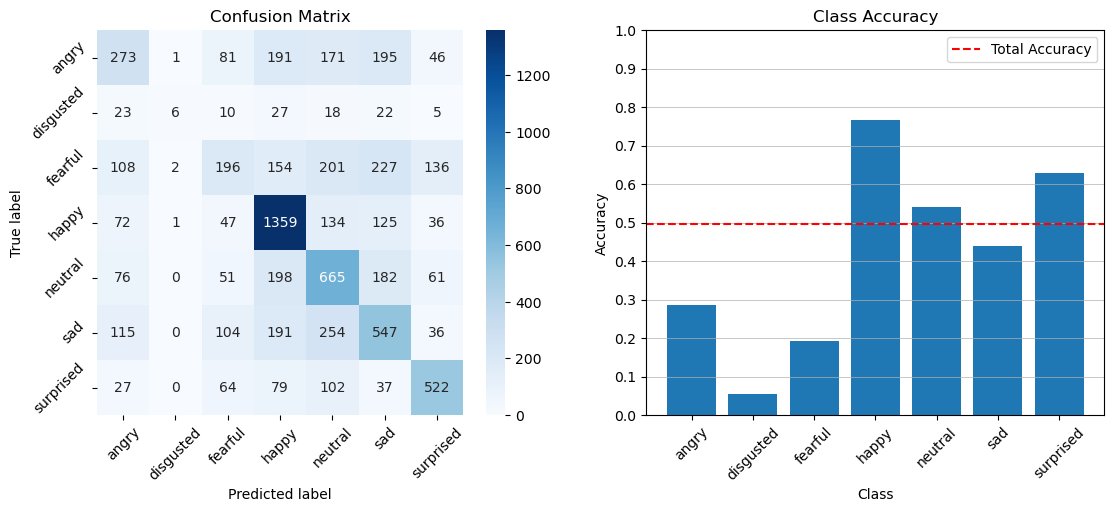

In [94]:
fig , ax = plt.subplots(1,2 , figsize=(13,5))
#cm heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Confusion Matrix')
ax[0].set_xticklabels(class_names, rotation=45)
ax[0].set_yticklabels(class_names, rotation=45)

#class accuracy
ax[1].bar(class_names, class_acc)
#add total accuracy as horizontal line
ax[1].axhline(accuracy_calculated, color='red', linestyle='--', label='Total Accuracy')
ax[1].legend()
ax[1].set_title('Class Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Class')
ax[1].set_xticklabels(class_names, rotation=45)
ax[1].set_ylim([0, 1])
#horizontal grid lines every 10%
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax[1].yaxis.grid(True, which='major', linewidth=0.5)
plt.show()



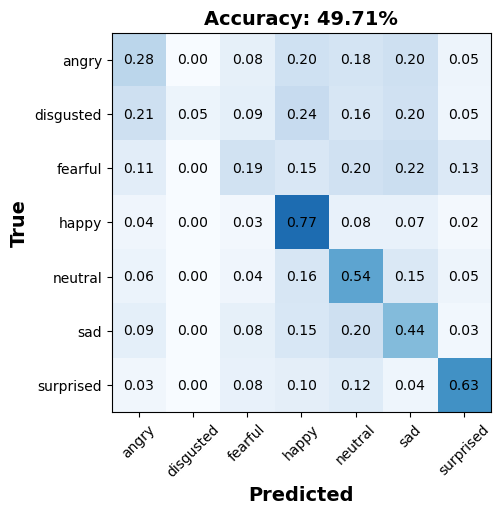

In [95]:
#Produce a cm across all classes
def plot_confusion_matrix(cm, class_names):
    figure, ax = plt.subplots(figsize=(5, 5))
    cm_norm = cm / tf.reduce_sum(cm, axis=1)[:, None]
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'), vmin=0, vmax=1)
    accuracy_ = np.trace(cm) / float(np.sum(cm))
    ax.set_title(f'Accuracy: {100*accuracy_:.2f}%', fontsize=14, fontweight='bold')
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color='k')

    figure.tight_layout()
    plt.xlabel('Predicted', fontweight='bold', fontsize=14)
    plt.ylabel('True', fontweight='bold', fontsize=14)

plot_confusion_matrix(cm, class_names)

plt.savefig('confusion_matrix_onlydense7.png', dpi=300, bbox_inches='tight')

In [106]:
save = True

if save: 
    model_name = "ResNet50V2_newDay_v3_nofinetuning"

    model.save(f"{model_name}.keras")

    # save hist loss and val loss to a csv file
    import pandas as pd
    hist_df = pd.DataFrame(hist)
    # hist_df = hist 
    hist_df.to_csv(f"{model_name}.csv", index=False)
    hist_df 


,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.339211,1.923407,0.418188,1.652449,0.00050
1,0.403719,1.677503,0.461159,1.514140,0.00050
2,0.454577,1.528034,0.464858,1.494714,0.00050
3,0.456529,1.506263,0.480359,1.445010,0.00050
4,0.495283,1.408180,0.481769,1.444547,0.00050
5,0.485684,1.415236,0.485820,1.422899,0.00050
6,0.514238,1.352083,0.486877,1.414066,0.00050
7,0.514228,1.344835,0.491985,1.405508,0.00050
8,0.534416,1.298810,0.490400,1.408701,0.00050
9,0.547311,1.281772,0.503259,1.372110,0.00005


In [61]:
def build_class_dataset():
    return image_dataset_from_directory(
                        f"class_archive",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        shuffle=False,
                        batch_size=1,
                        seed=42)

In [62]:
# Build test set and apply the preprocessing model to the test dataset
class_ds = build_class_dataset()
class_ds = class_ds.map(lambda x, y: (preprocessing_model(x), y))

# Predict the labels of the test dataset
y_pred = model.predict(class_ds, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in class_ds], axis=0)
y_true = np.argmax(y_true, axis=1)


class_cm = confusion_matrix(y_true, y_pred)


# Calculate accuracy
y_pred = np.array(y_pred)
y_true = np.array(y_true)

label_diff = y_pred - y_true
correct_predictions = len(y_true) - np.count_nonzero(label_diff)
accuracy_calculated = correct_predictions / len(y_true)
print("Calculated accuracy: ",accuracy_calculated)


# Find out accuracy of each class
class_acc = np.zeros(len(class_cm))
for i in range(len(class_cm)):
  class_acc[i] = class_cm[i, i] / np.sum(class_cm[i, :])
print("Class accuracy:",class_acc)



Found 404 files belonging to 7 classes.
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
Calculated accuracy:  0.30198019801980197
Class accuracy: [0.05454545 0.         0.01694915 0.96825397 0.36923077 0.59574468
 0.07936508]


2024-06-11 17:00:45.250270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


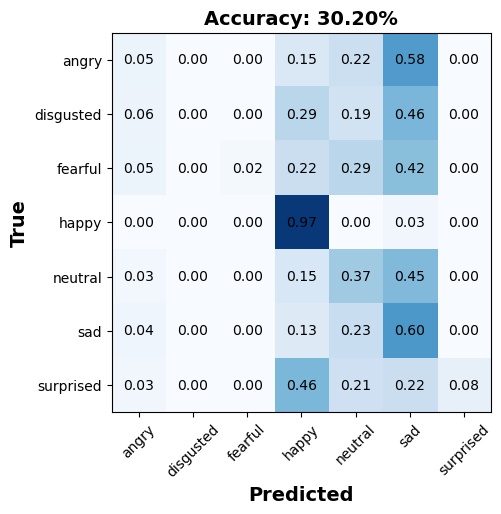

In [63]:
#Produce a cm across all classes
def plot_confusion_matrix(cm, class_names):
    figure, ax = plt.subplots(figsize=(5, 5))
    cm_norm = cm / tf.reduce_sum(cm, axis=1)[:, None]
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'), vmin=0, vmax=1)
    accuracy_ = np.trace(cm) / float(np.sum(cm))
    ax.set_title(f'Accuracy: {100*accuracy_:.2f}%', fontsize=14, fontweight='bold')
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color='k')

    figure.tight_layout()
    plt.xlabel('Predicted', fontweight='bold', fontsize=14)
    plt.ylabel('True', fontweight='bold', fontsize=14)

plot_confusion_matrix(class_cm, class_names)

/tmp/ipykernel_454/2408229307.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(class_names, rotation=45)


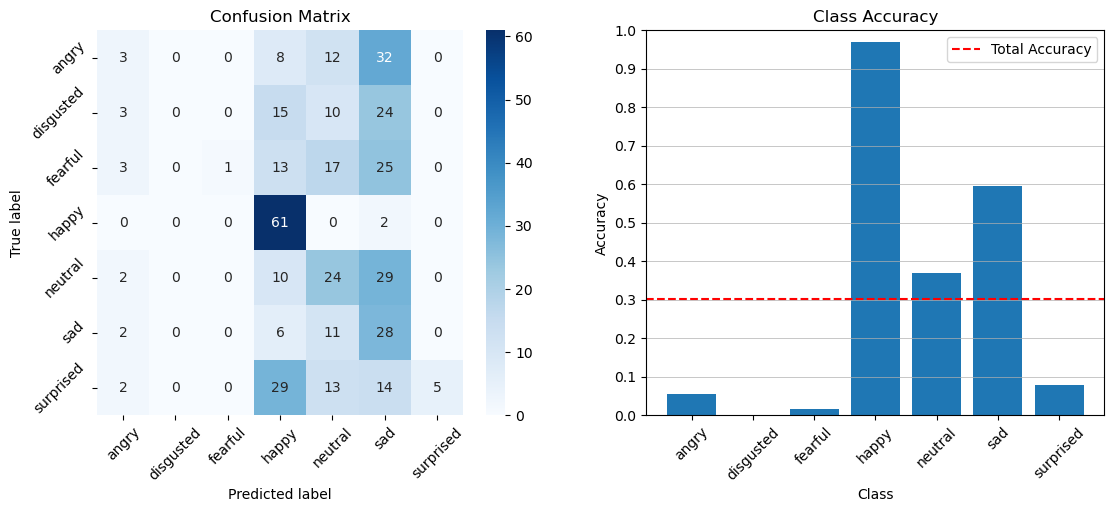

In [64]:
fig , ax = plt.subplots(1,2 , figsize=(13,5))
#cm heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Confusion Matrix')
ax[0].set_xticklabels(class_names, rotation=45)
ax[0].set_yticklabels(class_names, rotation=45)

#class accuracy
ax[1].bar(class_names, class_acc)
#add total accuracy as horizontal line
ax[1].axhline(accuracy_calculated, color='red', linestyle='--', label='Total Accuracy')
ax[1].legend()
ax[1].set_title('Class Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Class')
ax[1].set_xticklabels(class_names, rotation=45)
ax[1].set_ylim([0, 1])
#horizontal grid lines every 10%
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax[1].yaxis.grid(True, which='major', linewidth=0.5)
plt.show()


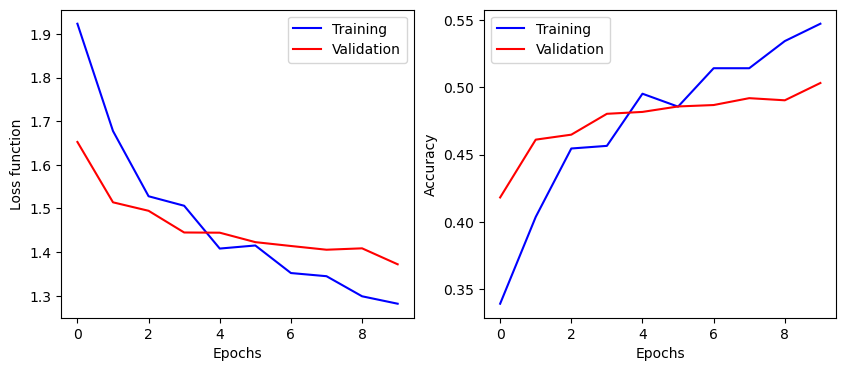

In [103]:
# load hist loss and val loss from a csv file 
# import pandas as pd
# hist_df = pd.read_csv("ResNet50V2_newDay_v3_63acc.csv")


fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(hist["loss"], label="Training", c='b')
ax[0].plot(hist["val_loss"], label="Validation", c='r')
ax[0].set_ylabel("Loss function")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(hist["accuracy"], label="Training", c='b')
ax[1].plot(hist["val_accuracy"], label="Validation", c='r')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].legend()

plt.savefig('ResNet50V2_newDay_v3_noFineTuning.png', dpi=300, bbox_inches='tight')